In [1]:
from qiskit import IBMQ

In [2]:
IBMQ.save_account('cf8f375261c4dccb5d21ed0a6faf0737c07de4dc8d9c99fcc41c122eb47bd554120b1834c246a505644ab913f0aee2df3efa33eff7d9517cd4d77aa4b4fb8430')
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')
available_backends = provider.backends()
print("Backends disponibili:")
for backend in available_backends:
    print(backend.name())

/tmp/ipykernel_558/2032875596.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account('cf8f375261c4dccb5d21ed0a6faf0737c07de4dc8d9c99fcc41c122eb47bd554120b1834c246a505644ab913f0aee2df3efa33eff7d9517cd4d77aa4b4fb8430')
/tmp/ipykernel_558/2032875596.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('cf8f375261c4dccb5d21ed0a6faf0737c07de4

Backends disponibili:
ibmq_qasm_simulator
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibm_brisbane
ibm_kyoto
ibm_osaka


In [3]:
backend = provider.get_backend('ibm_kyoto')

In [4]:
import numpy as np

np.random.seed(999999)
p0 = np.random.random()
target_distr = {0: p0, 1: 1 - p0}

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter

params = [Parameter("theta"), Parameter("phi"), Parameter("lam")]


def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name="c")
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc


qc = get_var_form(params)

In [6]:
from qiskit_aer.primitives import Sampler, Estimator

sampler = Sampler()


def objective_function(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Simulate the circuit instance with paramters
    result = sampler.run(circuits=qc, parameter_values=params).result()
    # Get the quasi distribution for each measured state
    output_distr = result.quasi_dists[0]
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(
        abs(target_distr.get(i, 0) - output_distr.get(i, 0))
        for i in range(2**qc.num_qubits)
    )
    return cost

In [7]:
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA

optimizer = COBYLA(maxiter=500, tol=0.0001)
# Create the initial parameters (noting that our
# single qubit variational form has 3 parameters)
initial_point = np.random.rand(3)

result = optimizer.minimize(fun=objective_function, x0=initial_point)

# Obtain the output distribution using the final parameters
output_distr = (
    sampler.run(circuits=qc, parameter_values=result.x)
    .result()
    .quasi_dists[0]
)

print("Parameters Found:", result.x)
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Cost:", objective_function(result.x))

Parameters Found: [0.36969581 0.69664069 1.97734227]
Target Distribution: {0: 0.308979188922057, 1: 0.691020811077943}
Obtained Distribution: {0: 0.337890625, 1: 0.662109375}
Cost: 0.008994747155885996


/tmp/ipykernel_558/603783229.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA


linear entanglement:


/home/riccardo/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


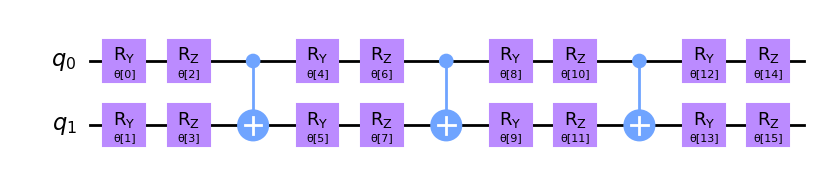

full entanglement:


/home/riccardo/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


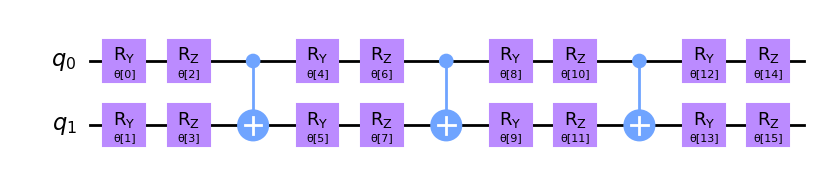

In [8]:
from qiskit.circuit.library import EfficientSU2

entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=2, entanglement=entanglement)
    print(f"{entanglement} entanglement:")
    # We initialize all parameters to 0 for this demonstration
    display(form.decompose().draw("mpl", fold=-1))

In [9]:
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

qiskit_nature.settings.use_pauli_sum_op = False  # pylint: disable=undefined-variable
# pylint: enable=line-too-long
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2

In [10]:
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

In [11]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [12]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored
# in Qiskit Terra, and are useful for extracting realistic noise models.

device = FakeVigo()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
noisy_estimator = Estimator(
    backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
)

In [13]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H"],
        coords=([0.0, 0.0, 0.0], [0.0, 0.0, dist]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.1, 2.0, 0.02)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)

# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    
    vqe = VQE(
        noisy_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

/home/riccardo/.venv/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Interatomic Distance: 0.1 VQE Result: 5.31845 Exact Energy: 2.70996
Interatomic Distance: 0.12 VQE Result: 3.97260 Exact Energy: 1.84290
Interatomic Distance: 0.14 VQE Result: 3.37716 Exact Energy: 1.22996
Interatomic Distance: 0.16 VQE Result: 2.59355 Exact Energy: 0.77642
Interatomic Distance: 0.18 VQE Result: 2.54753 Exact Energy: 0.42950
Interatomic Distance: 0.2 VQE Result: 2.60200 Exact Energy: 0.15748
Interatomic Distance: 0.22 VQE Result: 0.72723 Exact Energy: -0.05994
Interatomic Distance: 0.24 VQE Result: 2.72039 Exact Energy: -0.23636
Interatomic Distance: 0.26 VQE Result: 0.23074 Exact Energy: -0.38124
Interatomic Distance: 0.28 VQE Result: 0.95459 Exact Energy: -0.50139
Interatomic Distance: 0.3 VQE Result: 1.12095 Exact Energy: -0.60180
Interatomic Distance: 0.32 VQE Result: 0.74637 Exact Energy: -0.68628
Interatomic Distance: 0.34 VQE Result: 0.99379 Exact Energy: -0.75771
Interatomic Distance: 0.36 VQE Result: 0.55746 Exact Energy: -0.81837
Interatomic Distance: 0.38 VQ

In [14]:
from time import time
# Setup VQE algorithm
custom_vqe = CustomVQE(noisy_estimator, form, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
resultIBM = custom_vqe.compute_minimum_eigenvalue(qubit_op)
end = time()

print(resultIBM)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 260,
    'eigenstate': None,
    'eigenvalue': -0.8738679275930975,
    'optimal_circuit': None,
    'optimal_parameters': array([ -68668.94060109,  159009.85637772, -265398.01308876,
         12464.0056314 ,   27665.40816129, -311893.76411633,
       -104597.37027899,   16335.40435385, -109215.2255771 ,
        -61656.3549875 ,  -14255.94605808, -268172.57486366,
        157036.05434421,  321426.39641178,   37408.69451292,
        233355.73131819]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}


/tmp/ipykernel_558/1184782398.py:35: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQEResult`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQEResult``. See https://qisk.it/algo_migration for a migration guide.
  result = VQEResult()


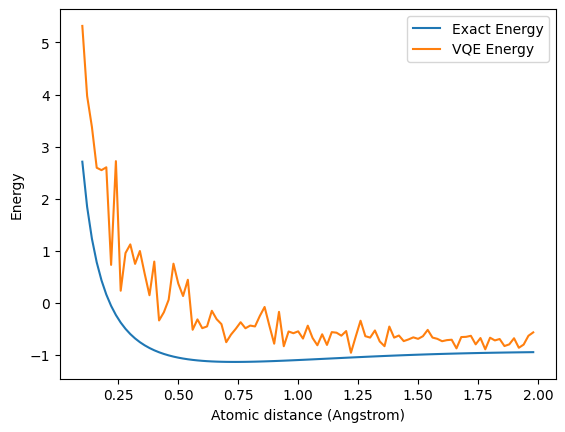

In [15]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

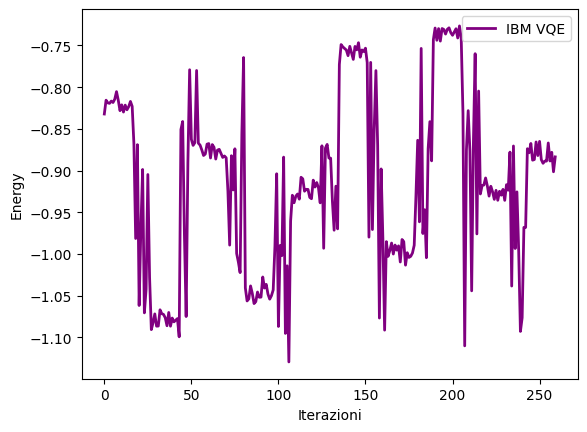

In [16]:
plt.plot(intermediate_info, color='purple', lw=2, label='IBM VQE')
plt.xlabel("Iterazioni")
plt.ylabel("Energy")
plt.legend()
plt.show()